In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from keras.datasets import mnist, fashion_mnist
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# Load Datasets (MNIST and Fashion-MNIST)

(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()
(X_train_fashion, y_train_fashion), (X_test_fashion, y_test_fashion) = fashion_mnist.load_data()

# Convert to torch tensors and normalize
X_train_mnist = torch.from_numpy(X_train_mnist).unsqueeze(1).float() / 255.0
X_test_mnist = torch.from_numpy(X_test_mnist).unsqueeze(1).float() / 255.0
y_train_mnist = torch.from_numpy(y_train_mnist).long()
y_test_mnist = torch.from_numpy(y_test_mnist).long()

X_train_fashion = torch.from_numpy(X_train_fashion).unsqueeze(1).float() / 255.0 # add channel dim at index 1. 1 -> grayscale
X_test_fashion = torch.from_numpy(X_test_fashion).unsqueeze(1).float() / 255.0
y_train_fashion = torch.from_numpy(y_train_fashion).long()
y_test_fashion = torch.from_numpy(y_test_fashion).long()

print("MNIST loaded:", X_train_mnist.shape, y_train_mnist.shape)
print("Fashion-MNIST loaded:", X_train_fashion.shape, y_train_fashion.shape)

MNIST loaded: torch.Size([60000, 1, 28, 28]) torch.Size([60000])
Fashion-MNIST loaded: torch.Size([60000, 1, 28, 28]) torch.Size([60000])


C:\Users\ginis\AppData\Local\Temp\ipykernel_12152\2560070024.py:12: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:209.)
  X_train_fashion = torch.from_numpy(X_train_fashion).unsqueeze(1).float() / 255.0 # add channel dim at index 1. 1 -> grayscale


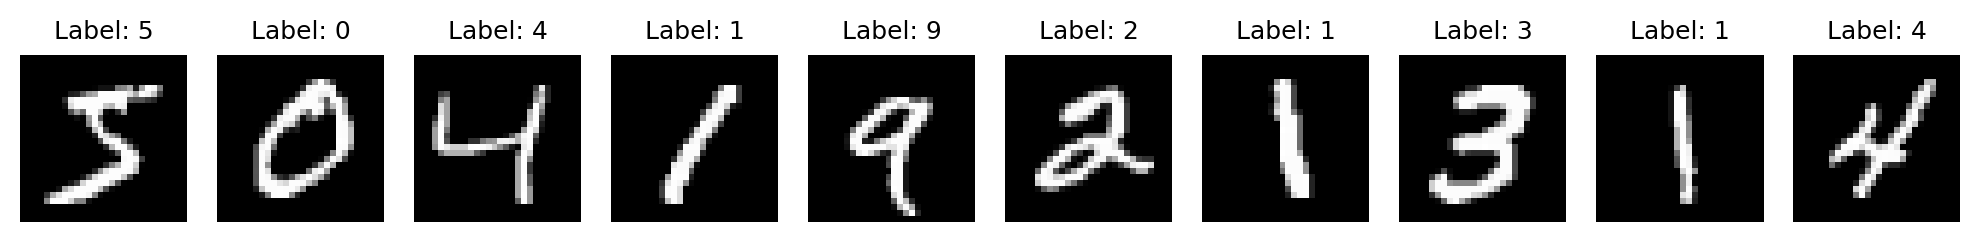

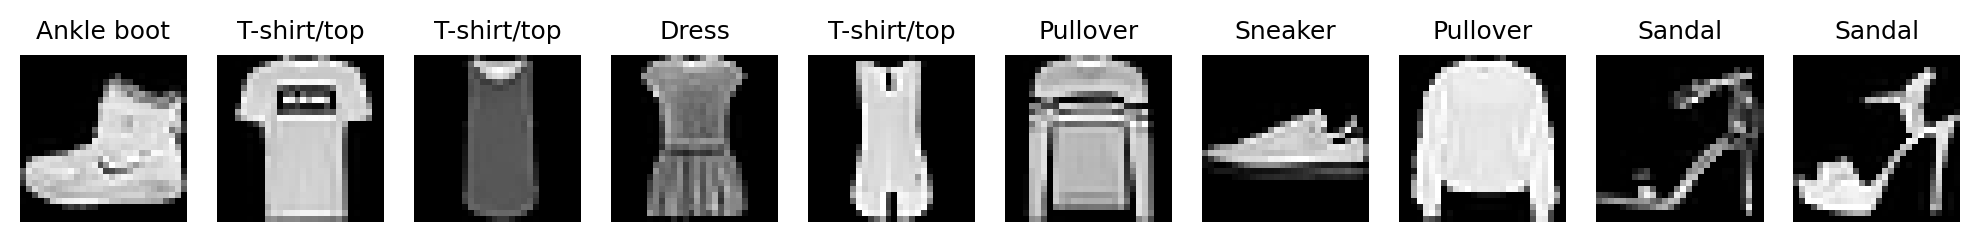

In [ ]:

# Fashion-MNIST label names
fashion_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

def plot_images(images, labels, num_images=5, is_fashion=False):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        img = images[i].detach().cpu().numpy().reshape(28, 28)
        label = labels[i].item()
        title = fashion_labels[label] if is_fashion else f"Label: {label}"
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(title, fontsize=9)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot 10 MNIST digits
plot_images(X_train_mnist, y_train_mnist, num_images=10)

# Plot 10 Fashion-MNIST items with names
plot_images(X_train_fashion, y_train_fashion, num_images=10, is_fashion=True)


In [39]:


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)  # input channel=1 for grayscale
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 13 * 13, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 32 * 13 * 13)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def get_feats(self, x):
        """Return features for t-SNE: embedding before final classifier (128-d)."""
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        feat = F.relu(self.fc1(x))
        out = self.fc2(feat)
        return feat.detach().cpu().numpy(), out.detach().cpu().numpy()


In [40]:


batch_size = 128
train_loader_mnist = DataLoader(TensorDataset(X_train_mnist, y_train_mnist), batch_size=batch_size, shuffle=True)
test_loader_mnist = DataLoader(TensorDataset(X_test_mnist, y_test_mnist), batch_size=batch_size, shuffle=False)

train_loader_fashion = DataLoader(TensorDataset(X_train_fashion, y_train_fashion), batch_size=batch_size, shuffle=True)
test_loader_fashion = DataLoader(TensorDataset(X_test_fashion, y_test_fashion), batch_size=batch_size, shuffle=False)



In [ ]:

# Train the Simple CNN on MNIST

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cnn = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

num_epochs = 5
print("\n🚀 Training Simple CNN on MNIST...")
for epoch in range(num_epochs):
    model_cnn.train()
    running_loss = 0.0
    for images, labels in train_loader_mnist:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader_mnist):.4f}")



🚀 Training Simple CNN on MNIST...
Epoch [1/5], Loss: 0.2836
Epoch [2/5], Loss: 0.0894
Epoch [3/5], Loss: 0.0581
Epoch [4/5], Loss: 0.0432
Epoch [5/5], Loss: 0.0328


In [ ]:
# Evaluation Function

import time
def evaluate(model, loader, transform_fn=None):
    model.eval()
    y_true, y_pred = [], []
    start_time = time.time()
    with torch.no_grad():
        for images, labels in loader:
            if transform_fn:
                images = transform_fn(images)
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    end_time = time.time()
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)
    inference_time = end_time - start_time
    return acc, f1, cm, inference_time

In [43]:

# ----------------------------------------------------
# 6. Pretrained Models (AlexNet & MobileNetV2)
# ----------------------------------------------------
transform_rgb = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x.repeat(1, 3, 1, 1))  # Convert (B,1,28,28) → (B,3,28,28)
])

alexnet = models.alexnet(pretrained=True)
alexnet.classifier[6] = nn.Linear(4096, 10)
alexnet = alexnet.to(device)
alexnet.eval()

mobilenet = models.mobilenet_v2(pretrained=True)
mobilenet.classifier[1] = nn.Linear(1280, 10)
mobilenet = mobilenet.to(device)
mobilenet.eval()

c:\Users\ginis\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ginis\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\ginis\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weight

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [44]:
import time
# ----------------------------------------------------
# 7. Evaluate All Models on MNIST Test Set
# ----------------------------------------------------
models_to_compare = {
    "SimpleCNN": (model_cnn, None),
    "AlexNet (pretrained)": (alexnet, transform_rgb),
    "MobileNetV2 (pretrained)": (mobilenet, transform_rgb)
}

results = {}

print("\n Evaluating Models...")
for name, (model, transform_fn) in models_to_compare.items():
    acc, f1, cm, t = evaluate(model, test_loader_mnist, transform_fn)
    params = sum(p.numel() for p in model.parameters())
    results[name] = {
        "Accuracy": acc,
        "F1-score": f1,
        "Params": params,
        "Inference Time (s)": t,
        "Confusion Matrix": cm
    }



 Evaluating Models...



===== SimpleCNN =====
Accuracy: 98.12%
F1-score: 0.9812
Parameters: 693,962
Inference Time: 1.15 sec


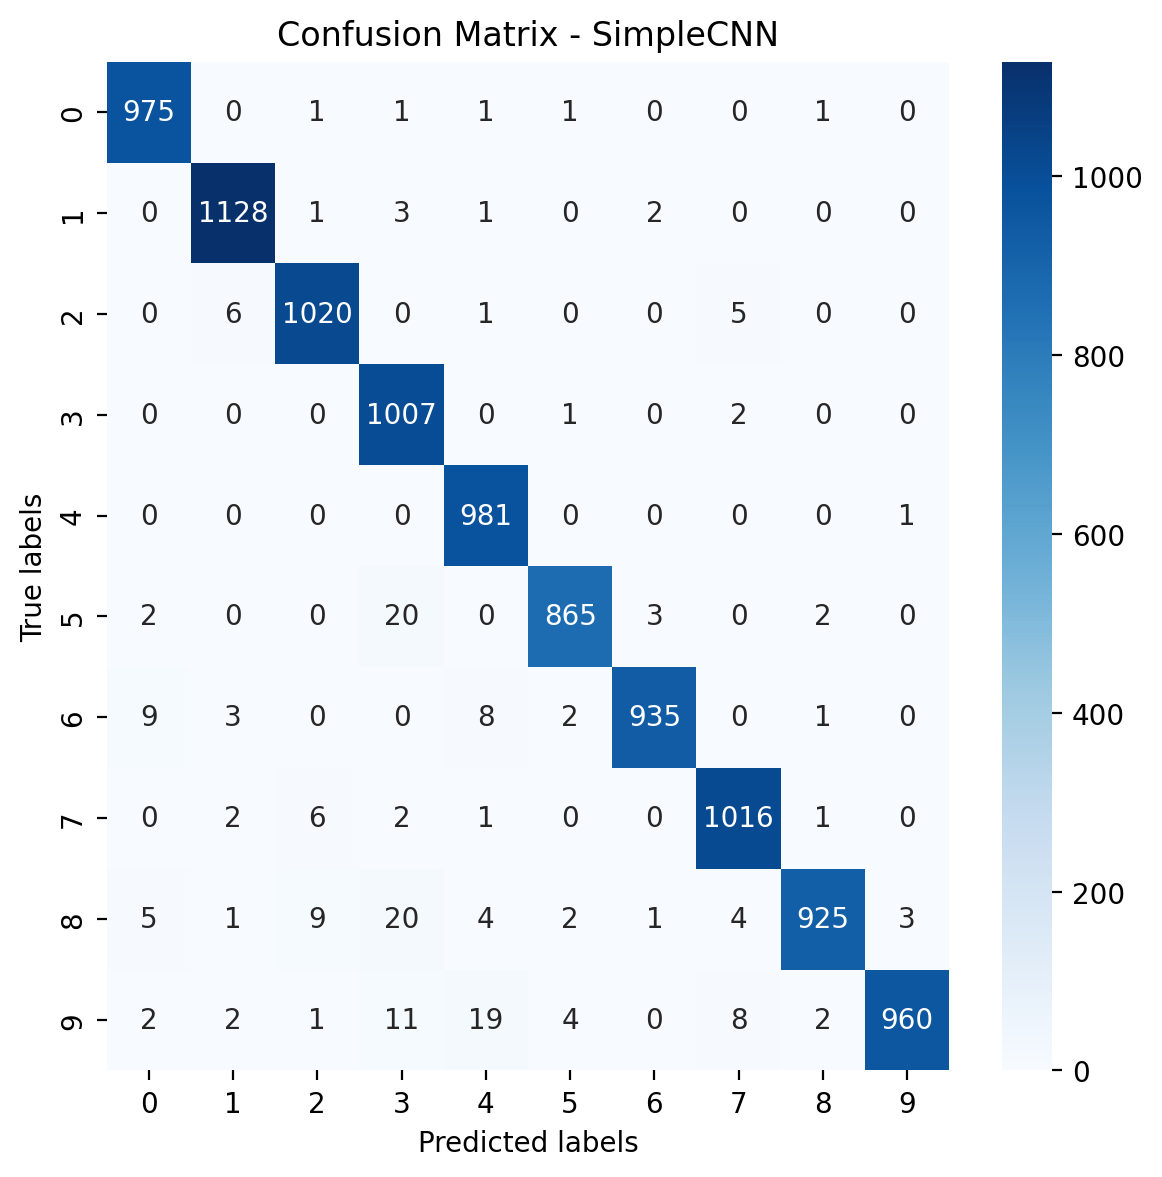

Most commonly confused with class 0: [8 2]
Most commonly confused with class 1: [3 6]
Most commonly confused with class 2: [1 7]
Most commonly confused with class 3: [7 5]
Most commonly confused with class 4: [9 8]
Most commonly confused with class 5: [3 6]
Most commonly confused with class 6: [0 4]
Most commonly confused with class 7: [2 3]
Most commonly confused with class 8: [3 2]
Most commonly confused with class 9: [4 3]

===== AlexNet (pretrained) =====
Accuracy: 5.99%
F1-score: 0.0201
Parameters: 57,044,810
Inference Time: 73.97 sec


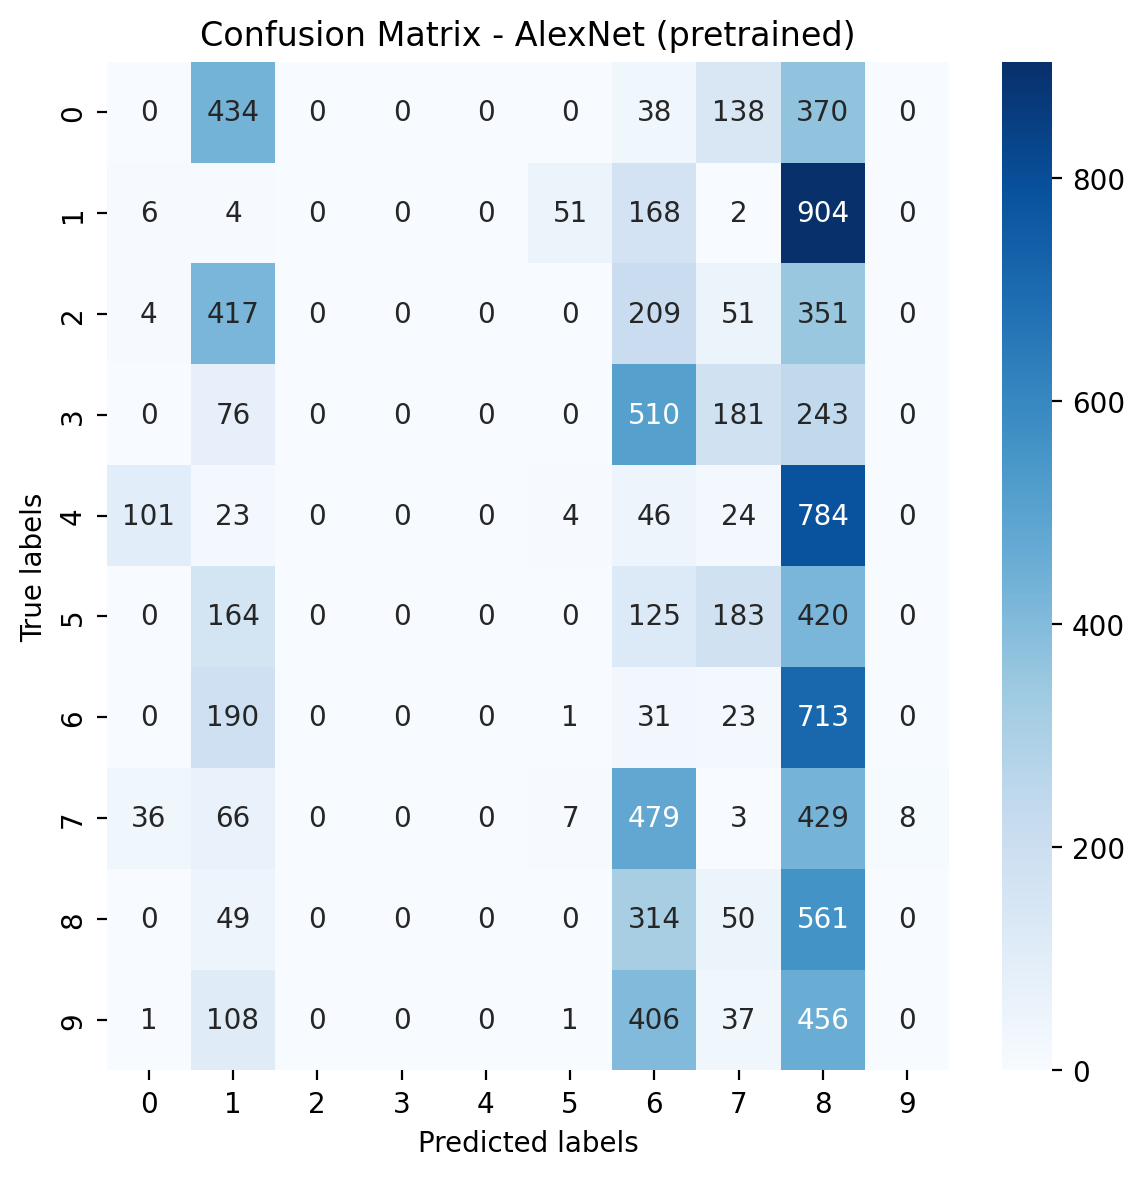

Most commonly confused with class 0: [8 7]
Most commonly confused with class 1: [6 5]
Most commonly confused with class 2: [8 6]
Most commonly confused with class 3: [8 7]
Most commonly confused with class 4: [0 6]
Most commonly confused with class 5: [7 1]
Most commonly confused with class 6: [1 6]
Most commonly confused with class 7: [8 1]
Most commonly confused with class 8: [6 7]
Most commonly confused with class 9: [6 1]

===== MobileNetV2 (pretrained) =====
Accuracy: 14.10%
F1-score: 0.0494
Parameters: 2,236,682
Inference Time: 199.09 sec


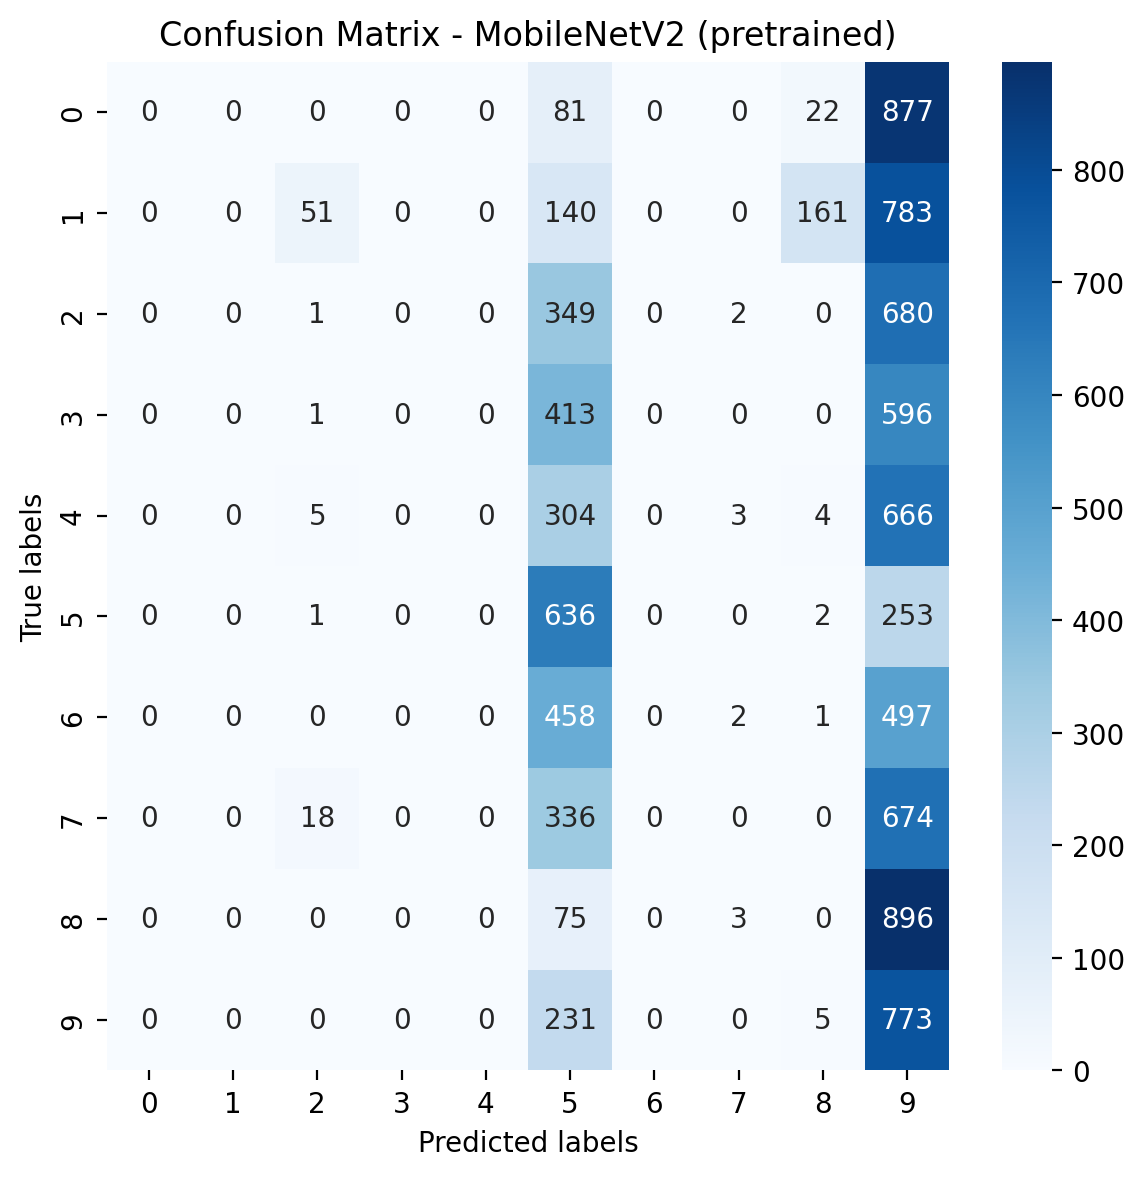

Most commonly confused with class 0: [5 8]
Most commonly confused with class 1: [8 5]
Most commonly confused with class 2: [5 7]
Most commonly confused with class 3: [5 2]
Most commonly confused with class 4: [5 2]
Most commonly confused with class 5: [9 8]
Most commonly confused with class 6: [5 7]
Most commonly confused with class 7: [5 2]
Most commonly confused with class 8: [5 7]
Most commonly confused with class 9: [5 8]


In [45]:
# ----------------------------------------------------
# 8. Display Comparison
# ----------------------------------------------------
for name, r in results.items():
    print(f"\n===== {name} =====")
    print(f"Accuracy: {r['Accuracy']*100:.2f}%")
    print(f"F1-score: {r['F1-score']:.4f}")
    print(f"Parameters: {r['Params']:,}")
    print(f"Inference Time: {r['Inference Time (s)']:.2f} sec")
    # print("Confusion Matrix:\n", r["Confusion Matrix"])

    # Extract confusion matrix
    cm = r["Confusion Matrix"]

    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.tight_layout()
    plt.show()

    # Show most commonly confused classes
    num_classes = cm.shape[0]
    for i in range(num_classes):
        # Skip if only 1 class
        if num_classes < 2:
            continue
        confused_with = cm[i].argsort()[-3:-1][::-1]
        print(f"Most commonly confused with class {i}: {confused_with}")


## Model Comparison Overview

Three CNN models were compared on the MNIST dataset:

- **SimpleCNN** – a custom model with one convolutional layer (32 filters, 3×3 kernel), max pooling, one fully connected layer (128 neurons), and an output layer (10 neurons).  
- **AlexNet (Pretrained)** – a deeper, older architecture designed for large-scale RGB images.  
- **MobileNetV2 (Pretrained)** – a lightweight model optimized for efficiency on large datasets.


## Performance Metrics

| Model | Accuracy | F1-Score | Parameters | Inference Time |
|:------|:----------|:----------|:------------|:----------------|
| SimpleCNN | 98.12% | 0.9812 | 693,962 | 1.15 sec |
| AlexNet (Pretrained) | 5.99% | 0.0201 | 57,044,810 | 73.97 sec |
| MobileNetV2 (Pretrained) | 14.10% | 0.0494 | 2,236,682 | 199.09 sec |



## Confusion Matrix Insights

- SimpleCNN shows strong diagonal dominance in the confusion matrix, meaning it predicts most digits correctly.  
- Only minor confusion occurs between similar-looking digits such as 8 and 2, 4 and 9 or 3 and 9.  
- AlexNet and MobileNetV2, despite being pretrained, perform poorly because they were trained on ImageNet (colored, natural images) and not grayscale digits.  
- Their learned features (edges, textures, and colors) do not transfer well to the MNIST dataset.  
- AlexNet tends to misclassify multiple digits as 8 or 9, while MobileNetV2 heavily confuses most digits into a few dominant classes.


## Parameter and Speed Comparison

- SimpleCNN has far fewer parameters (≈0.7M) and still achieves excellent accuracy.  
- AlexNet has around 57M parameters, which makes it much slower without improving accuracy on MNIST.  
- MobileNetV2, although smaller than AlexNet, is still slower and less accurate because its depthwise convolutions are not optimized for single-channel (grayscale) input.



## Key Observations

- A small, task-specific CNN like SimpleCNN significantly outperforms large pretrained models on simple grayscale datasets such as MNIST.  
- Pretrained models require fine-tuning or input adaptation (e.g., converting grayscale to 3-channel RGB) to perform reasonably well.  
- The results highlight that model simplicity, data relevance, and proper training are often more effective than model size or pretraining on unrelated datasets.



## Conclusion

- The SimpleCNN achieves the best trade-off between accuracy, model size, and inference speed.  
- Pretrained models like AlexNet and MobileNetV2 are inefficient for MNIST without retraining or fine-tuning.  
- This experiment demonstrates the importance of designing architectures according to dataset characteristics rather than relying on model complexity.


In [ ]:
def plot_tsne(model, X_data, y_data, device='cpu', samples_per_class=500):
    model.eval()

    # --- Balanced Subsampling --- = To get equal samples per class
    y_np = np.array(y_data)
    X_list, y_list = [], []
    for c in np.unique(y_np):
        idx = np.where(y_np == c)[0]
        chosen = np.random.choice(idx, min(samples_per_class, len(idx)), replace=False)
        X_list.append(X_data[chosen])
        y_list.append(y_np[chosen])
    X_tensor = torch.cat(X_list).to(device)
    y_subset = np.concatenate(y_list)
    print(f"Using {len(y_subset)} samples ({samples_per_class} per class) for t-SNE")

    # --- Get feature embeddings --- 
    with torch.no_grad():
        feat_np, _ = model.get_feats(X_tensor)
    feat_np = (feat_np - feat_np.mean(axis=0)) / (feat_np.std(axis=0) + 1e-6)

    # --- Run t-SNE ---
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
    embeddings_2d = tsne.fit_transform(feat_np)

    # --- Plot ---
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_subset, cmap='tab10', s=5)
    plt.legend(*scatter.legend_elements(), title="Digits", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("t-SNE Visualization — CNN Embeddings (Subset)")
    plt.show()


C:\Users\ginis\AppData\Local\Temp\ipykernel_27432\3642308265.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_np = np.array(y_data)


Using 5000 samples (500 per class) for t-SNE


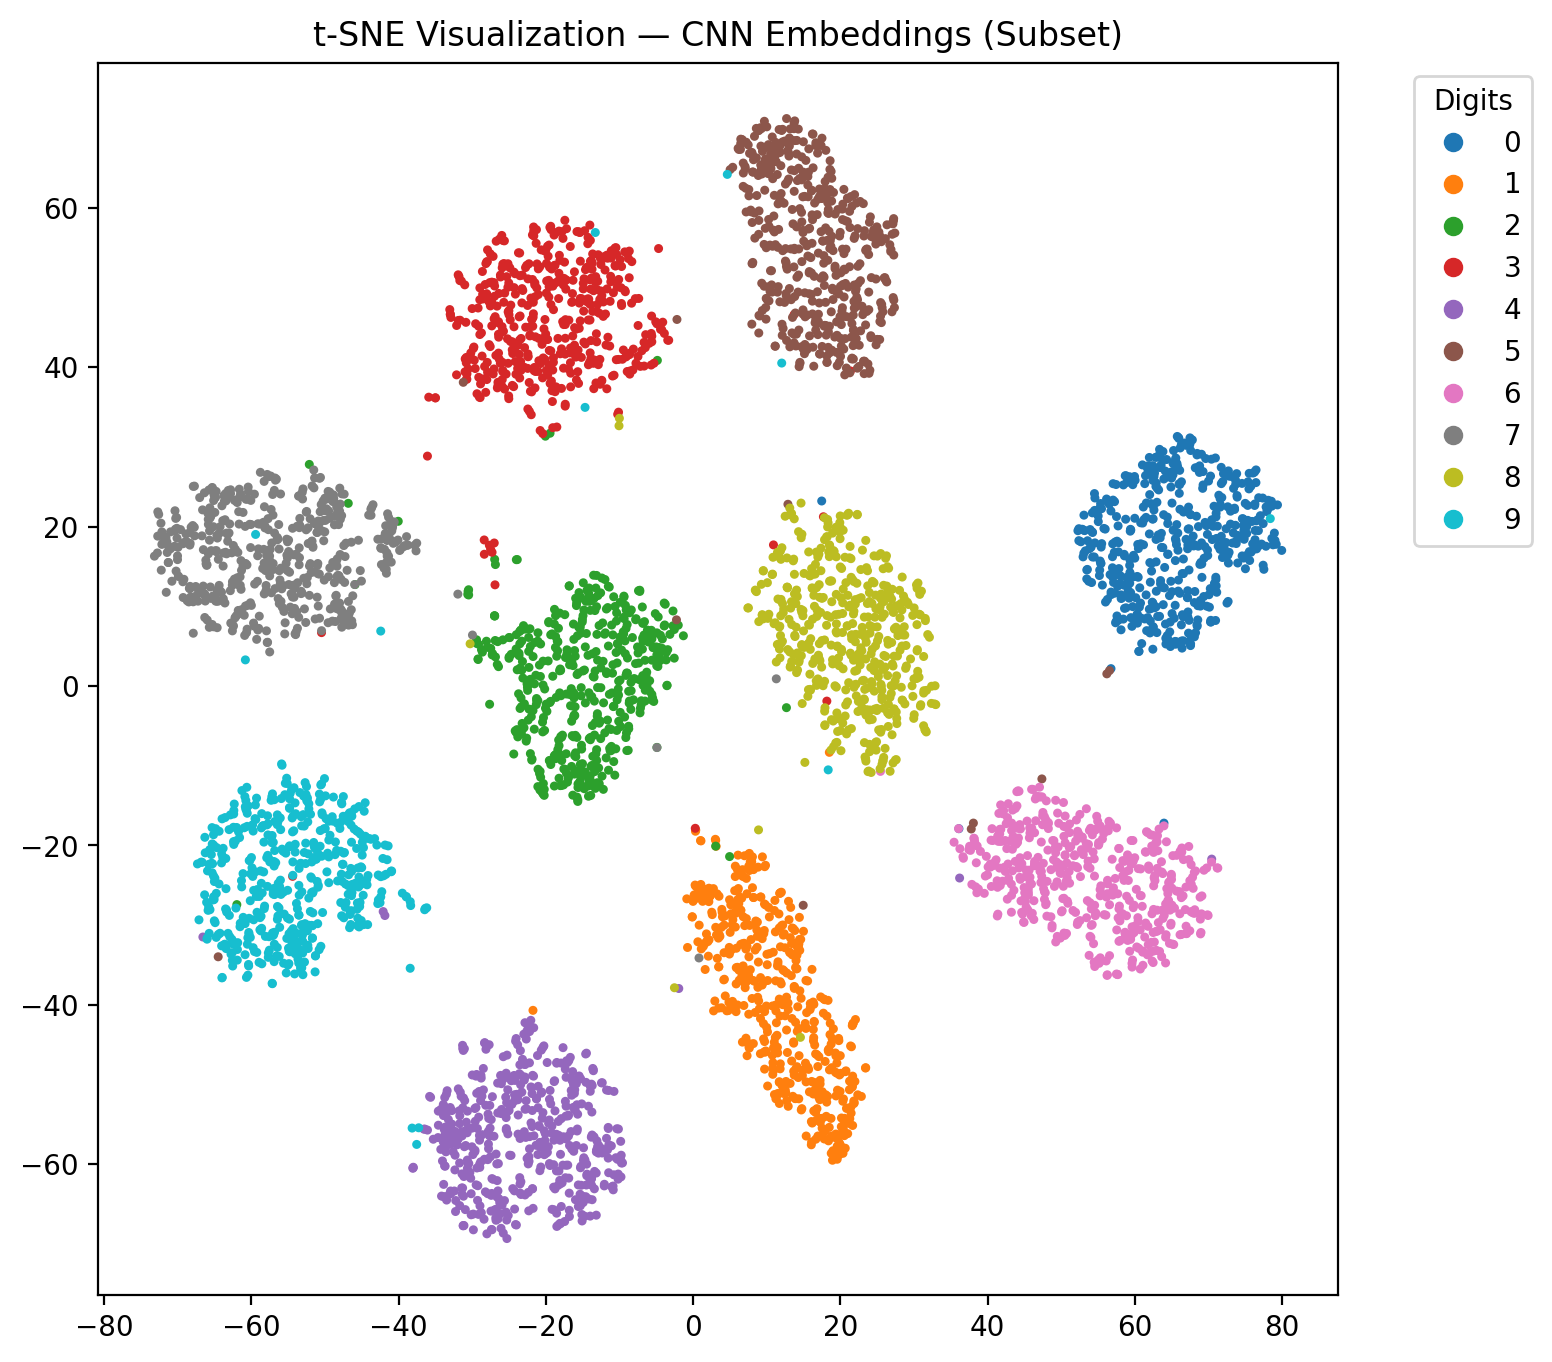

C:\Users\ginis\AppData\Local\Temp\ipykernel_27432\3642308265.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_np = np.array(y_data)


Using 5000 samples (500 per class) for t-SNE


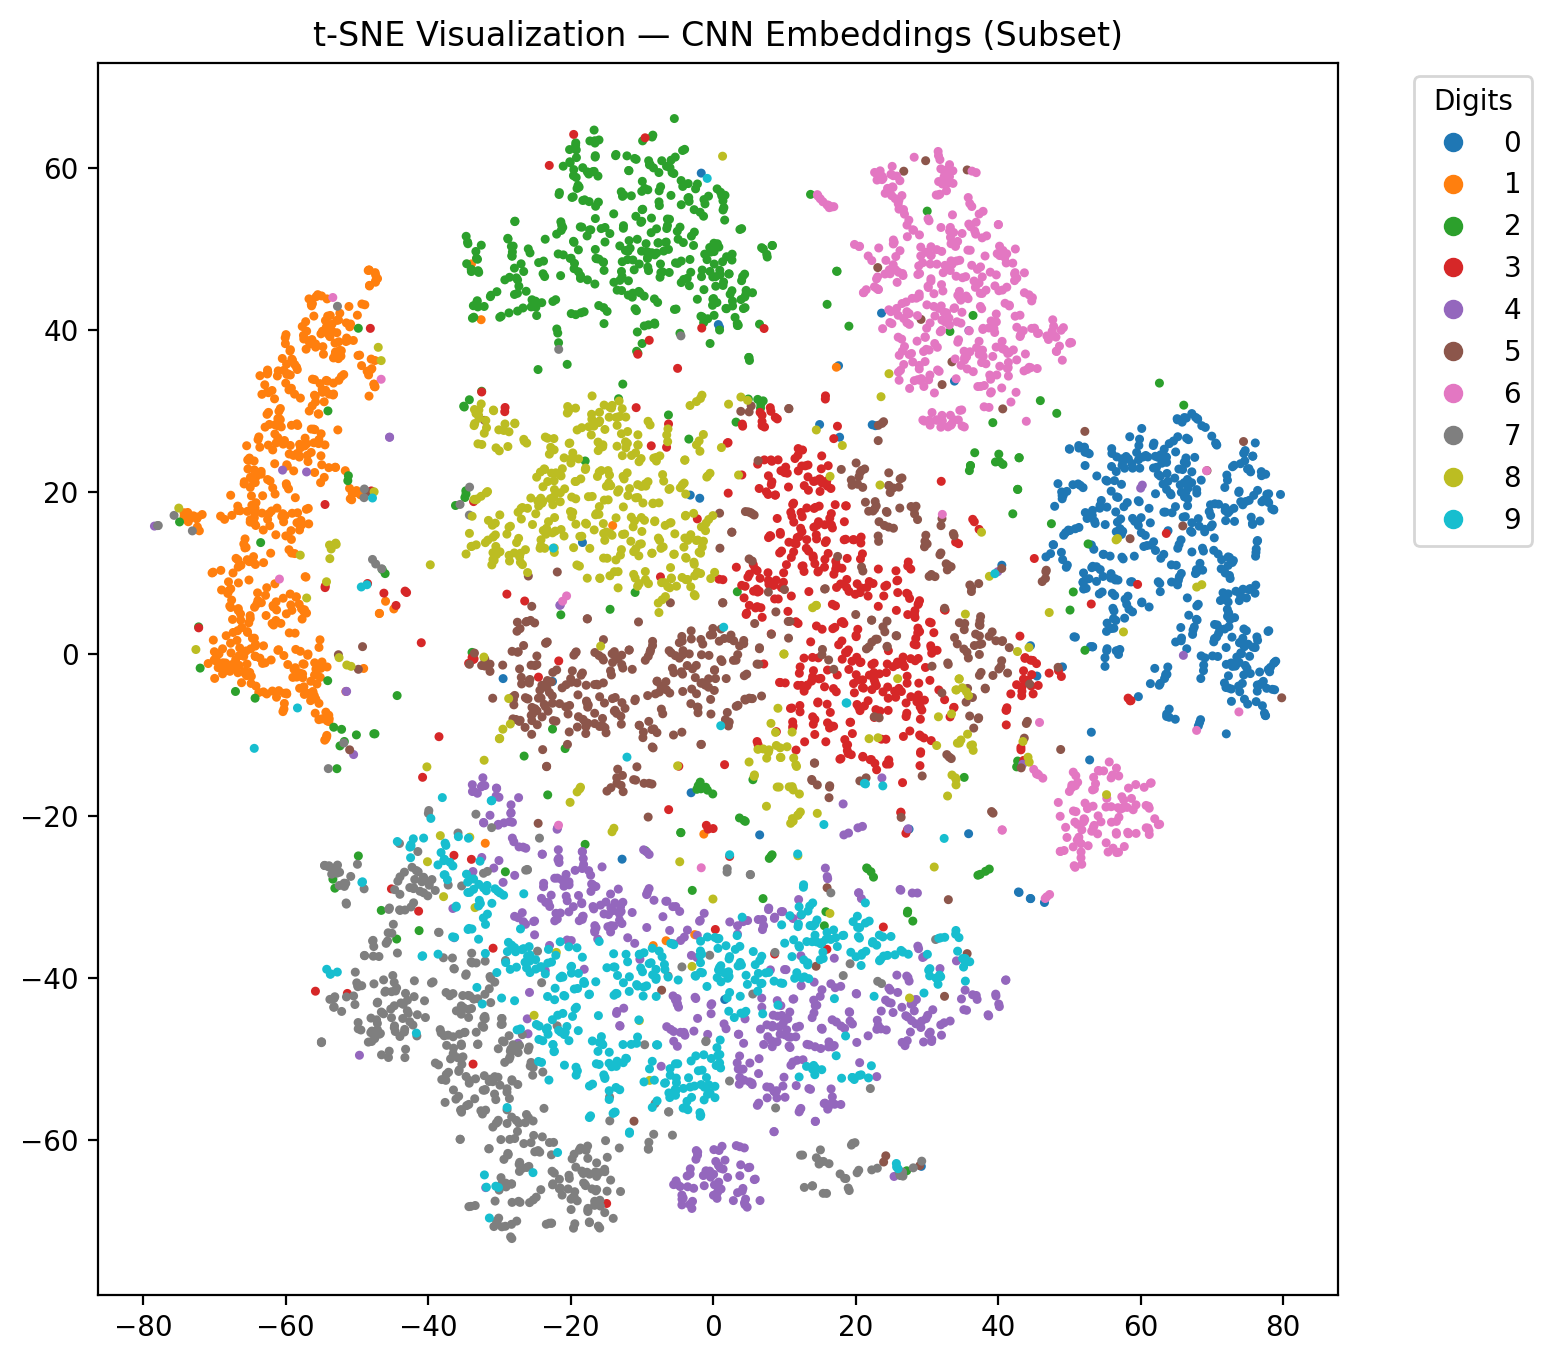

In [47]:
untrained_model = SimpleCNN()
plot_tsne(model_cnn, X_train_mnist, y_train_mnist, device=device)
plot_tsne(untrained_model, X_train_mnist, y_train_mnist, device=device)


## Observation and Comparison of t-SNE Visualizations

### 1. Trained Model (Top Plot)
- The embeddings form well-separated, compact clusters, each representing one of the ten digits (0–9).
- The CNN has learned meaningful feature representations where images of the same digit lie close together, while different digits are far apart.
- Digits with similar visual structures (e.g., 4 & 9 or 3 & 8) are relatively close but still distinct.

### 2. Untrained Model (Bottom Plot)
- The embeddings are randomly scattered with significant overlap between classes.
- There is no clear separation between digits, showing that the untrained CNN produces unstructured and meaningless features.
- Since the model weights are random, it cannot yet extract digit-specific features.

### 3. Overall Comparison

| Aspect | Trained Model | Untrained Model |
|:--------|:---------------|:----------------|
| Cluster separation | Clear, distinct clusters for each digit | Overlapping, random distribution |
| Feature structure | Meaningful, digit-specific | Unstructured, random |
| Interpretation | Network has learned effective representations of digits | Network has not learned any meaningful features |

### 4. Conclusion
The t-SNE visualizations clearly demonstrate the CNN’s learning process.  
Before training, the feature embeddings are random and mixed.  
After training, the CNN transforms the input space into a structured representation where each digit forms a distinct cluster.  
This shows that the intermediate layers of the trained CNN capture essential visual features required for accurate classification.


Cross-domain Test Accuracy: 0.1167, F1-score: 0.0918


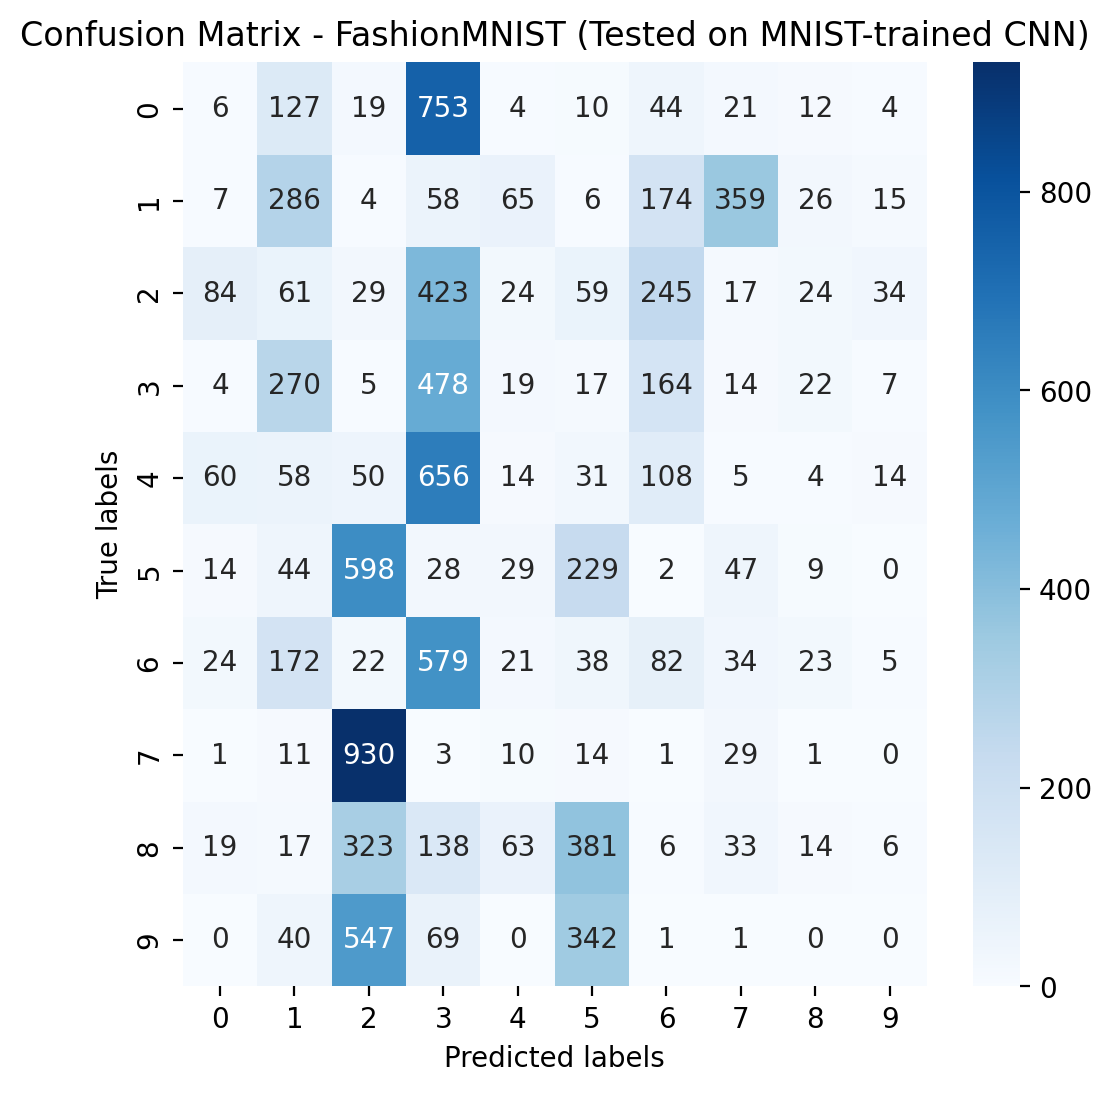

Most commonly confused with 0: [1 6]
Most commonly confused with 1: [1 6]
Most commonly confused with 2: [6 0]
Most commonly confused with 3: [1 6]
Most commonly confused with 4: [6 0]
Most commonly confused with 5: [5 7]
Most commonly confused with 6: [1 6]
Most commonly confused with 7: [7 5]
Most commonly confused with 8: [2 3]
Most commonly confused with 9: [5 3]


In [ ]:

model_cnn.eval()
y_true_fashion, y_pred_fashion = [], []

with torch.no_grad():
    for images, labels in test_loader_fashion:
        images = images.to(device)
        outputs_fashion = model_cnn(images)  
        preds_fashion = torch.argmax(outputs_fashion, dim=1).cpu().numpy()
        y_pred_fashion.extend(preds_fashion)
        y_true_fashion.extend(labels.numpy())

acc_fashion = accuracy_score(y_true_fashion, y_pred_fashion)
f1_fashion = f1_score(y_true_fashion, y_pred_fashion, average='macro')
print(f"Cross-domain Test Accuracy: {acc_fashion:.4f}, F1-score: {f1_fashion:.4f}")

cm_fashion = confusion_matrix(y_true_fashion, y_pred_fashion)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm_fashion, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - FashionMNIST (Tested on MNIST-trained CNN)')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# Print common confusions
for i in range(10):
    if cm_fashion[i].sum() > 0:
        print(f"Most commonly confused with {i}: {cm_fashion[i].argsort()[-3:-1][::-1]}")


Cross-domain Test Accuracy: 0.1167, F1-score: 0.0918


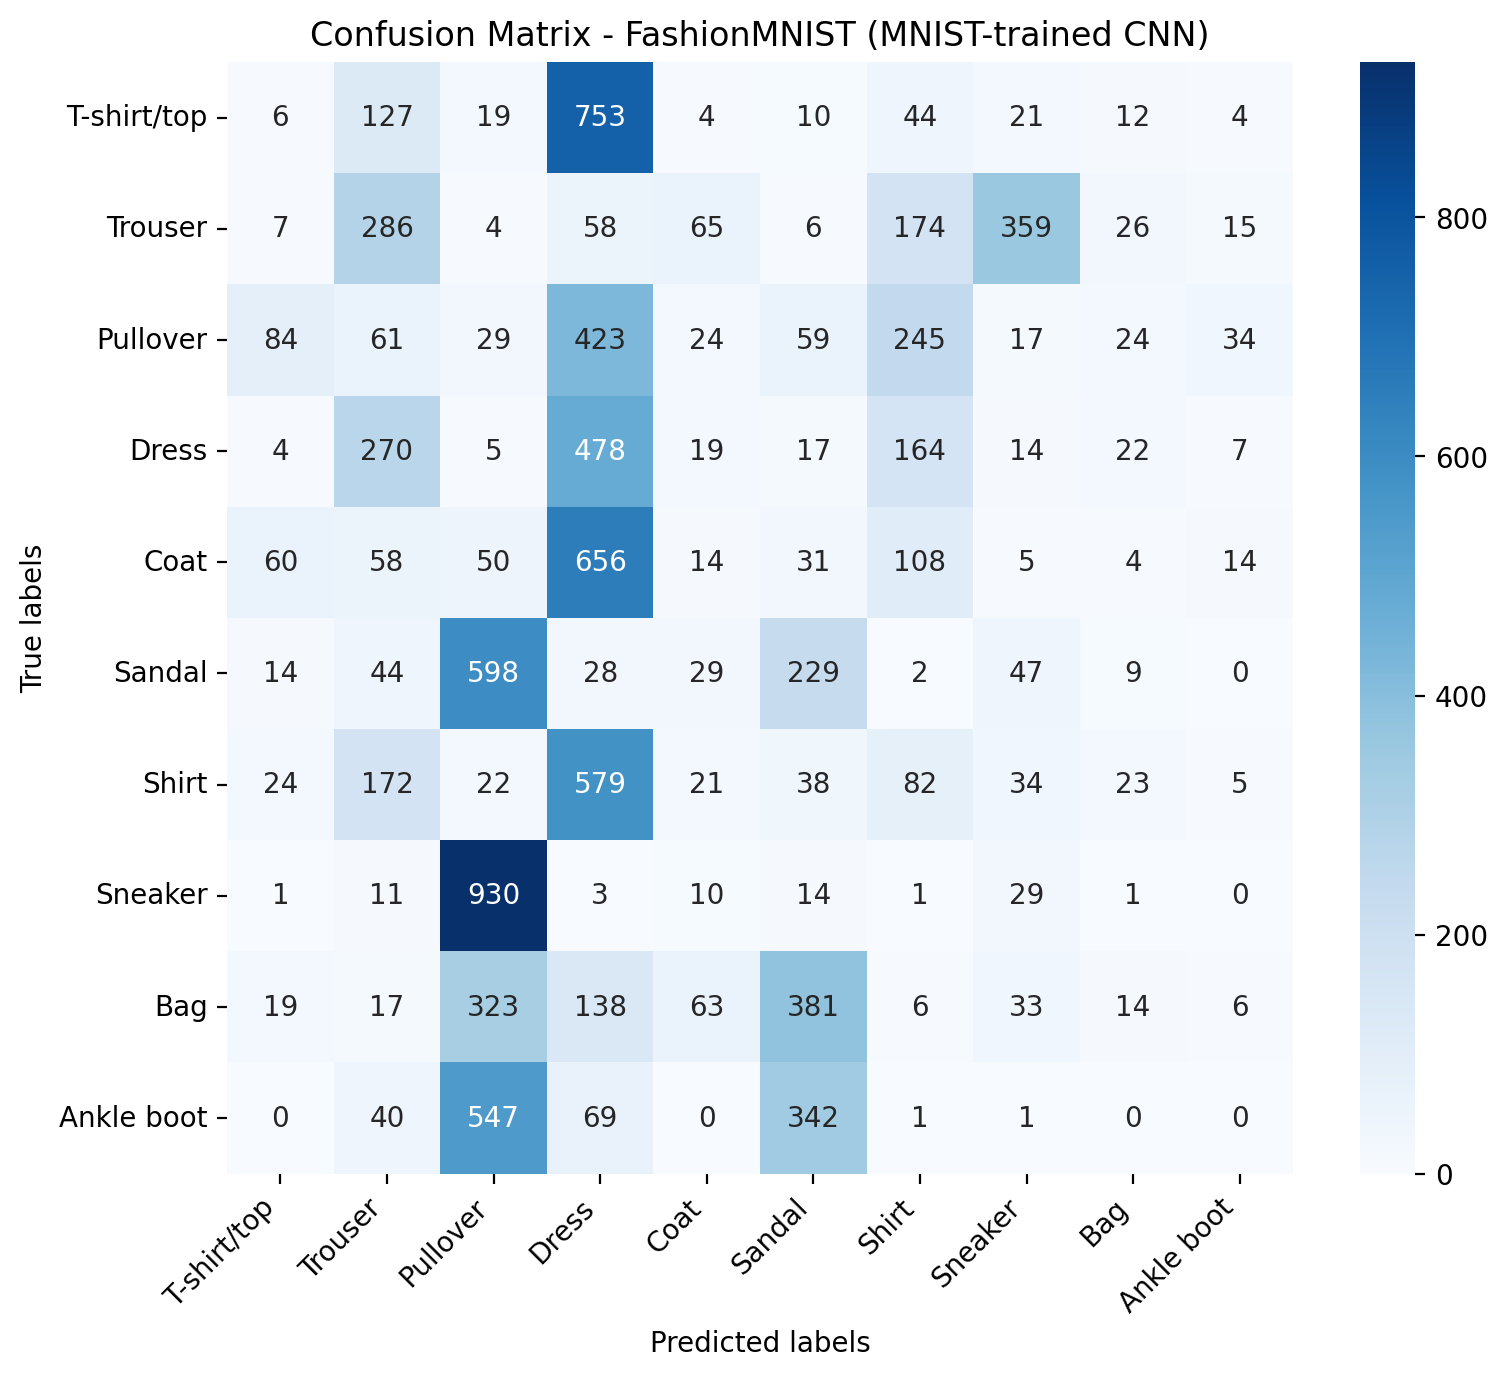

T-shirt/top is most confused with: Trouser and Shirt
Trouser is most confused with: Trouser and Shirt
Pullover is most confused with: Shirt and T-shirt/top
Dress is most confused with: Trouser and Shirt
Coat is most confused with: Shirt and T-shirt/top
Sandal is most confused with: Sandal and Sneaker
Shirt is most confused with: Trouser and Shirt
Sneaker is most confused with: Sneaker and Sandal
Bag is most confused with: Pullover and Dress
Ankle boot is most confused with: Sandal and Dress


In [ ]:

# FashionMNIST label names
fashion_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

model_cnn.eval()
y_true_fashion, y_pred_fashion = [], []

with torch.no_grad():
    for images, labels in test_loader_fashion:
        images = images.to(device)
        outputs_fashion = model_cnn(images) 
        preds_fashion = torch.argmax(outputs_fashion, dim=1).cpu().numpy()
        y_pred_fashion.extend(preds_fashion)
        y_true_fashion.extend(labels.numpy())

acc_fashion = accuracy_score(y_true_fashion, y_pred_fashion)
f1_fashion = f1_score(y_true_fashion, y_pred_fashion, average='macro')
print(f"Cross-domain Test Accuracy: {acc_fashion:.4f}, F1-score: {f1_fashion:.4f}")

cm_fashion = confusion_matrix(y_true_fashion, y_pred_fashion)

# Plot confusion matrix with readable labels
plt.figure(figsize=(8, 7))
sns.heatmap(cm_fashion, annot=True, fmt='d', cmap='Blues',
            xticklabels=fashion_labels, yticklabels=fashion_labels)
plt.title('Confusion Matrix - FashionMNIST (MNIST-trained CNN)')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print most confused classes in words
for i in range(10):
    if cm_fashion[i].sum() > 0:
        top_confused = cm_fashion[i].argsort()[-3:-1][::-1]
        print(f"{fashion_labels[i]} is most confused with: {fashion_labels[top_confused[0]]} and {fashion_labels[top_confused[1]]}")


In [50]:

print('Test Data Classification Report:')
print(classification_report(y_true_fashion, y_pred_fashion, target_names=fashion_labels))


Test Data Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.03      0.01      0.01      1000
     Trouser       0.26      0.29      0.27      1000
    Pullover       0.01      0.03      0.02      1000
       Dress       0.15      0.48      0.23      1000
        Coat       0.06      0.01      0.02      1000
      Sandal       0.20      0.23      0.22      1000
       Shirt       0.10      0.08      0.09      1000
     Sneaker       0.05      0.03      0.04      1000
         Bag       0.10      0.01      0.02      1000
  Ankle boot       0.00      0.00      0.00      1000

    accuracy                           0.12     10000
   macro avg       0.10      0.12      0.09     10000
weighted avg       0.10      0.12      0.09     10000



TSNE For MNIST:
Using 5000 samples (500 per class) for t-SNE


C:\Users\ginis\AppData\Local\Temp\ipykernel_27432\3642308265.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_np = np.array(y_data)


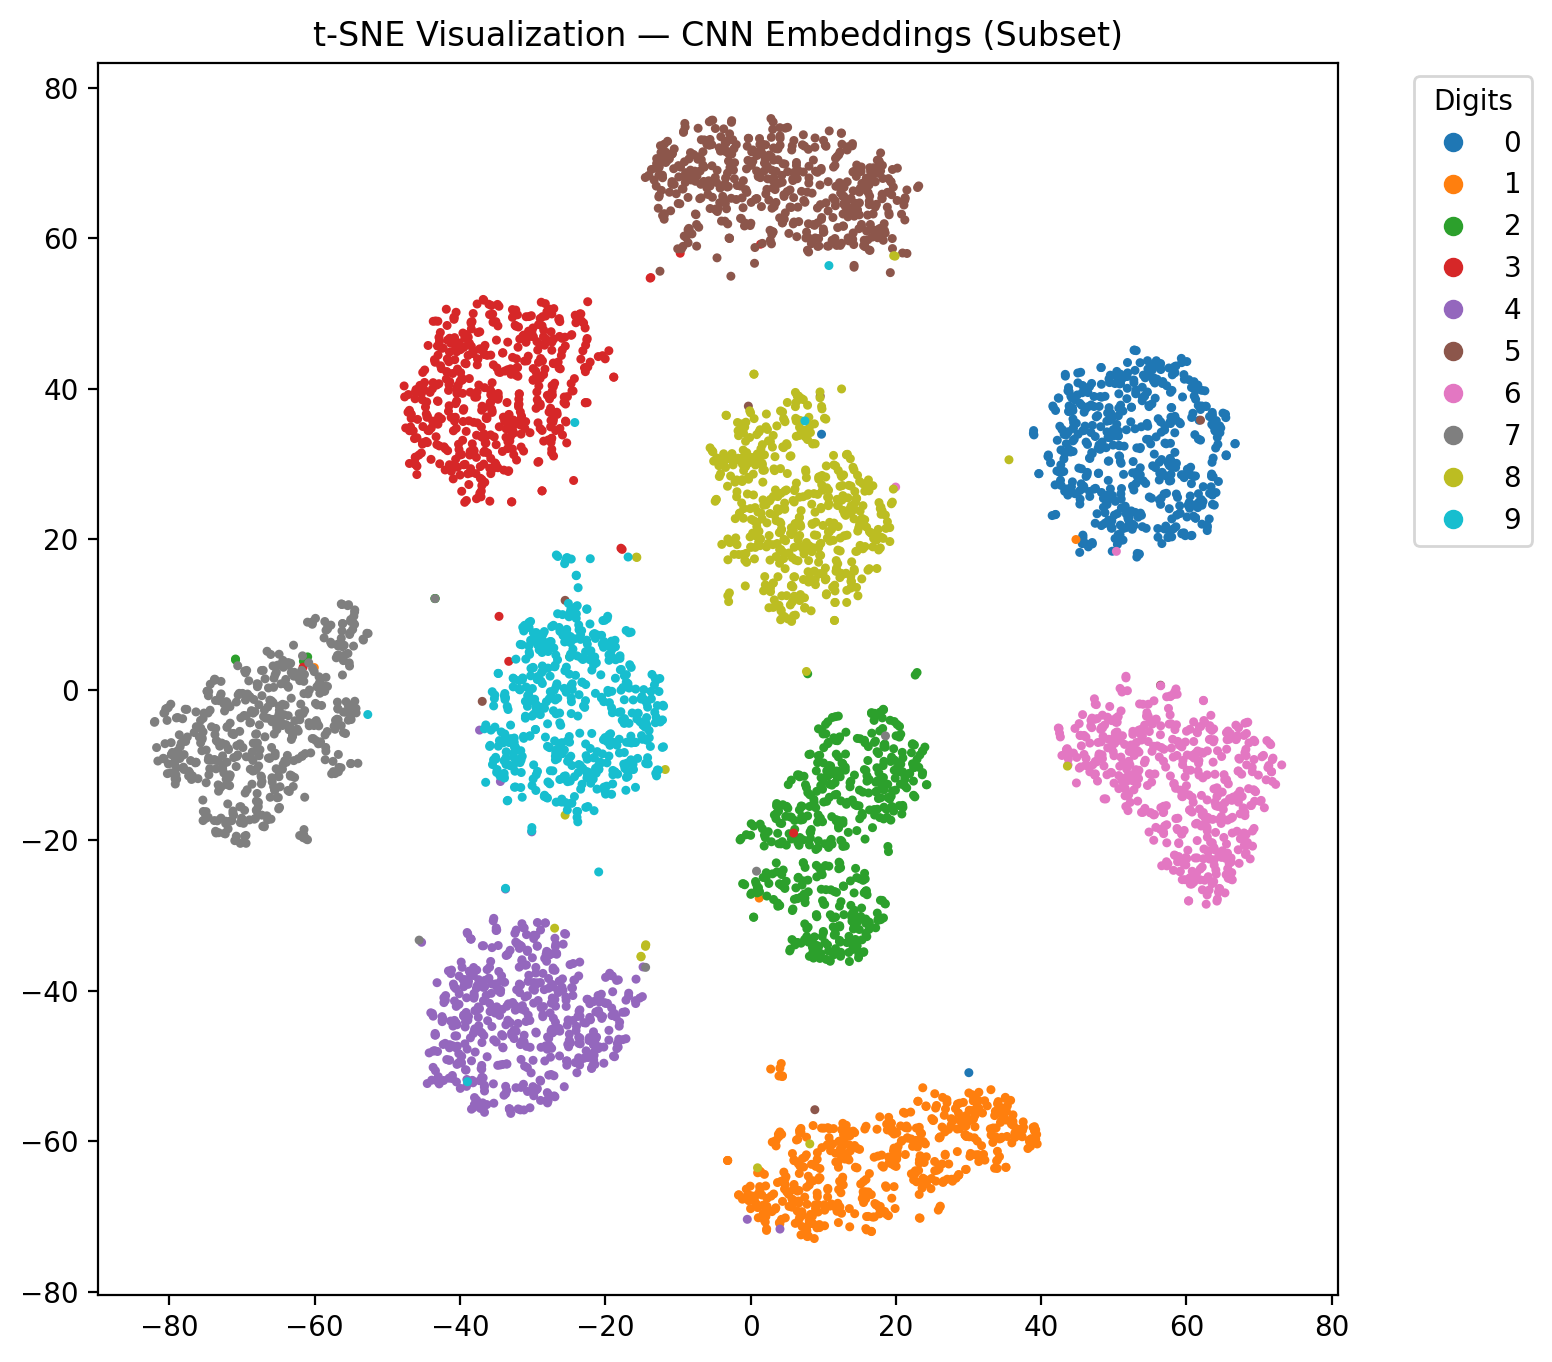

----------------------------------------------------------------------------------------------------
TSNE For Fashion MNIST:
Using 5000 samples (500 per class) for t-SNE


C:\Users\ginis\AppData\Local\Temp\ipykernel_27432\3642308265.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_np = np.array(y_data)


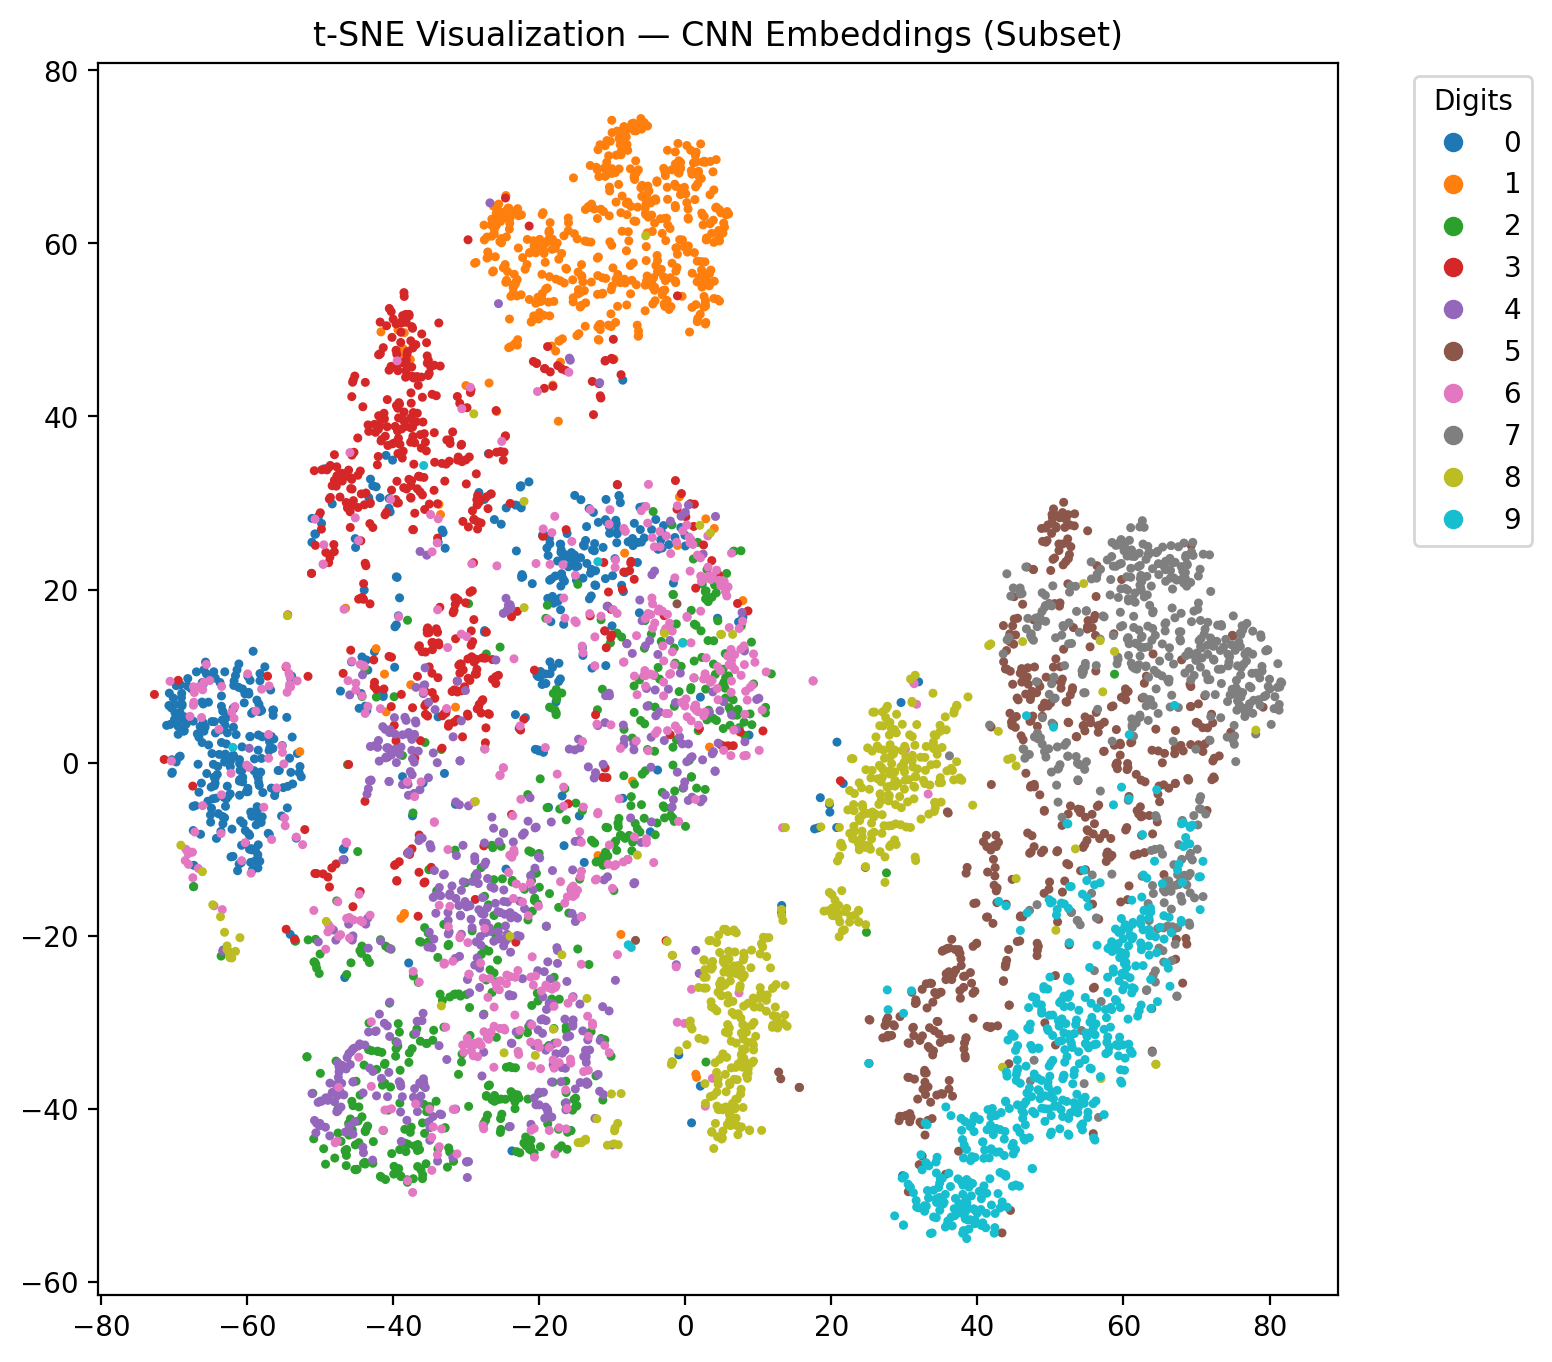

In [51]:
print('TSNE For MNIST:')
plot_tsne(model_cnn, X_train_mnist, y_train_mnist, device=device)

print("-"*100)
print('TSNE For Fashion MNIST:')
plot_tsne(model_cnn, X_train_fashion, y_train_fashion, device=device)


## Observations: Cross-domain Testing (MNIST-trained CNN on Fashion-MNIST)

### Performance Summary
- When the CNN trained on MNIST was tested on the Fashion-MNIST dataset, the accuracy dropped drastically to around **11.6%** with an **F1-score of 0.09**.
- This shows that the model completely failed to generalize to the new domain (Fashion-MNIST), even though both datasets have the same image size (28x28) and grayscale format.
- The poor performance highlights that the learned features in MNIST (simple digit strokes) do not transfer well to Fashion-MNIST (complex textures and shapes).

### Confusion Matrix Insights
- The confusion matrix shows very high misclassification rates, with many classes overlapping.
- The model predicted similar classes like *T-shirt/top*, *Trouser*, and *Shirt* incorrectly for most images.
- Classes with similar visual textures (e.g., *Pullover*, *Coat*, *Dress*) were frequently confused with each other.
- The network seems biased toward predicting certain dominant classes (e.g., class 3 and 8) due to pattern similarity with MNIST digits.

### t-SNE Visualization Comparison
- The t-SNE plot for MNIST embeddings shows clear, well-separated clusters for each digit, indicating strong feature discrimination learned during training.
- However, the t-SNE plot for Fashion-MNIST embeddings (using MNIST-trained CNN) shows overlapping and mixed clusters.
- This overlap means the model’s learned features from MNIST are not meaningful for Fashion-MNIST. It cannot distinguish clothing types because its convolutional filters are tuned to detect edges and strokes typical of digits.

### Conclusion
- The MNIST-trained CNN performs poorly on Fashion-MNIST due to domain shift like differences in visual structure, texture, and feature distribution between digits and clothing images.
- Effective cross-domain generalization would require transfer learning or domain adaptation to fine-tune the model on Fashion-MNIST data.
- The t-SNE plots clearly visualize this difference: compact and separated clusters for MNIST vs. overlapping and disorganized clusters for Fashion-MNIST.
